# This is an recruting project for the intership of "Project Adaptation of LLMs for Code Generation" at JetBrains in the summer of 2025.

In [1]:
# Imports
!pip install -q transformers datasets accelerate peft bitsandbytes
!pip install -U bitsandbytes
!pip install -q bitsandbytes>=0.39.0
!pip install -q evaluate sacrebleu
!pip install -q pytest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import sys
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import torch
from datasets import load_dataset, Dataset
import json
import evaluate
import numpy as np
from transformers import DataCollatorForLanguageModeling
import torch
import evaluate
from IPython.core.display import display, HTML
import subprocess
import os
from huggingface_hub import InferenceClient, login

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [3]:
# Dataset preparation

In [4]:
sys.set_int_max_str_digits(100000)

def safe_parse(json_str):
    """Robust JSON parsing with error handling"""
    try:
        return json.loads(json_str) if json_str.strip() else None
    except json.JSONDecodeError:
        return None

def format_prompt(example):
    """Prompt structure for code generation"""

    return f"""Write Python code to solve this problem:
Problem: {example['question']}
Input: {example['input_output'].get('inputs', [''])[0]}
Output: {example['input_output'].get('outputs', [''])[0]}
Your solution must:
- Be under 400 lines
- Use efficient algorithms
- Include proper error handling

Solution Code:
"""

def load_filtered_apps_dataset(split="train", max_samples=500):
    """Improved dataset loading with better filtering"""
    ds = load_dataset("codeparrot/apps", split=split, trust_remote_code=True)

    filtered = []
    for ex in ds:
        try:
            ex['solutions'] = safe_parse(ex['solutions']) or []
            ex['input_output'] = safe_parse(ex['input_output']) or {'inputs': [], 'outputs': []}

            if (len(ex['solutions']) > 0 and
                len(ex['input_output']['inputs']) > 0 and
                len(ex['question']) < 500 and
                any(len(sol) < 400 for sol in ex['solutions'])):

                filtered.append({
                    'prompt': format_prompt(ex),
                    'solution': ex['solutions'][0]
                })

        except Exception as e:
            print(f"Skipping {ex['problem_id']}: {str(e)}")

    return Dataset.from_list(filtered[:max_samples])


In [5]:
# Configure LoRA

In [6]:
# Llama Configuration
model_name = "meta-llama/Llama-3.2-1B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # Strictly speaking, this requires better hardware to fully utilize its potential
    bnb_4bit_compute_dtype=torch.float16
)


HF_API_KEY = os.getenv("HF_API_KEY")
if HF_API_KEY is None:
    try:
        from google.colab import userdata
        HF_API_KEY = userdata.get("HF_API_KEY")
        print("Using API key from Colab userdata.")
    except ImportError:
        print("No API key found. Running locally.")

# Load Model & Tokenizer
login(token=HF_API_KEY)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# LoRA Setup for LLama
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
model.gradient_checkpointing_enable()

Using API key from Colab userdata.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [7]:
# Preprocessing with proper labels
def preprocess(examples):
    texts = [p + s for p, s in zip(examples["prompt"], examples["solution"])]

    # Tokenize text
    tokenized = tokenizer(
        texts,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Compute prompt lengths
    prompt_lens = [
        len(tokenizer(p, add_special_tokens=False)["input_ids"])
        for p in examples["prompt"]
    ]

    # Mask prompt tokens in labels
    labels = []
    for input_ids, plen in zip(tokenized["input_ids"], prompt_lens):
        label = torch.full(input_ids.shape, -100, dtype=torch.long)  # Initialize with -100
        label[plen:] = input_ids[plen:]  # Only keep the solution part
        labels.append(label)

    # Convert labels list to tensor
    tokenized["labels"] = torch.stack(labels)

    return tokenized

# Prepare dataset splits
dataset = load_filtered_apps_dataset()
tokenized_data = dataset.map(preprocess, batched=True, remove_columns=["prompt", "solution"])
tokenized_data = tokenized_data.train_test_split(test_size=0.1)

README.md:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

apps.py:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/107M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [8]:
print(dataset[0]["prompt"])

Write Python code to solve this problem:
Problem: Your task is to calculate ab mod 1337 where a is a positive integer and b is an extremely large positive integer given in the form of an array.


Example1:

a = 2
b = [3]

Result: 8



Example2:

a = 2
b = [1,0]

Result: 1024



Credits:Special thanks to @Stomach_ache for adding this problem and creating all test cases.
Input: [2, [3]]
Output: 8
Your solution must:
- Be under 400 lines
- Use efficient algorithms
- Include proper error handling

Solution Code:



In [9]:
print(dataset[0]["solution"])

class Solution:
     def superPow(self, a, b):
         result = 1
         fermatb = (int(''.join(map(str, b)))) % 570
         while fermatb:
             if fermatb & 1:
                 result = (result * a) % 1337
             a = (a * a) % 1337
             fermatb >>= 1
         return result


In [19]:
chrf = evaluate.load("chrf")



def compute_metrics(pred):

    labels_ids = pred.label_ids
    pred_ids = pred.predictions[0]

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)


    # Compute CHRF++
    results = chrf.compute(
        predictions=pred_str,
        references=label_str,
        word_order=2,
        beta=2
    )




    return {"chrf": results["score"]}


def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """

    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
print(tokenized_data['train'])

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 450
})


In [12]:
from transformers import TrainerCallback
from transformers import Trainer

# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=7e-5,
    fp16=True,
    bf16=False,  # Ensure you're not using both bf16 and fp16
    optim="adamw_bnb_8bit",  # Use memory-efficient optimizer
    fp16_full_eval=True,  # FP16 for evaluation
    eval_accumulation_steps=1,
    logging_steps=20,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,
    report_to="none"
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    compute_metrics = compute_metrics,
    preprocess_logits_for_metrics = preprocess_logits_for_metrics
)

class ClearCacheCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        torch.cuda.empty_cache()
        print("Cleared GPU cache at the end of epoch", state.epoch)
        return control

trainer.add_callback(ClearCacheCallback())

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [13]:
# Start training
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Chrf
1,1.666200,1.352664,64.460281
2,1.378200,1.250712,66.716114
3,1.192100,1.226169,67.417873
4,1.211000,1.213647,67.768458
5,1.104000,1.208144,67.763095
6,1.118300,1.207278,67.725606
7,1.076000,1.205248,67.880533
8,1.085900,1.205726,67.853957
9,1.043700,1.206611,67.787330


Cleared GPU cache at the end of epoch 1.0
Cleared GPU cache at the end of epoch 2.0
Cleared GPU cache at the end of epoch 3.0
Cleared GPU cache at the end of epoch 4.0
Cleared GPU cache at the end of epoch 5.0
Cleared GPU cache at the end of epoch 6.0
Cleared GPU cache at the end of epoch 7.0
Cleared GPU cache at the end of epoch 8.0
Cleared GPU cache at the end of epoch 9.0
Cleared GPU cache at the end of epoch 9.666666666666666


TrainOutput(global_step=280, training_loss=1.1720639433179583, metrics={'train_runtime': 1364.9083, 'train_samples_per_second': 3.297, 'train_steps_per_second': 0.205, 'total_flos': 1.3107468045385728e+16, 'train_loss': 1.1720639433179583, 'epoch': 9.666666666666666})

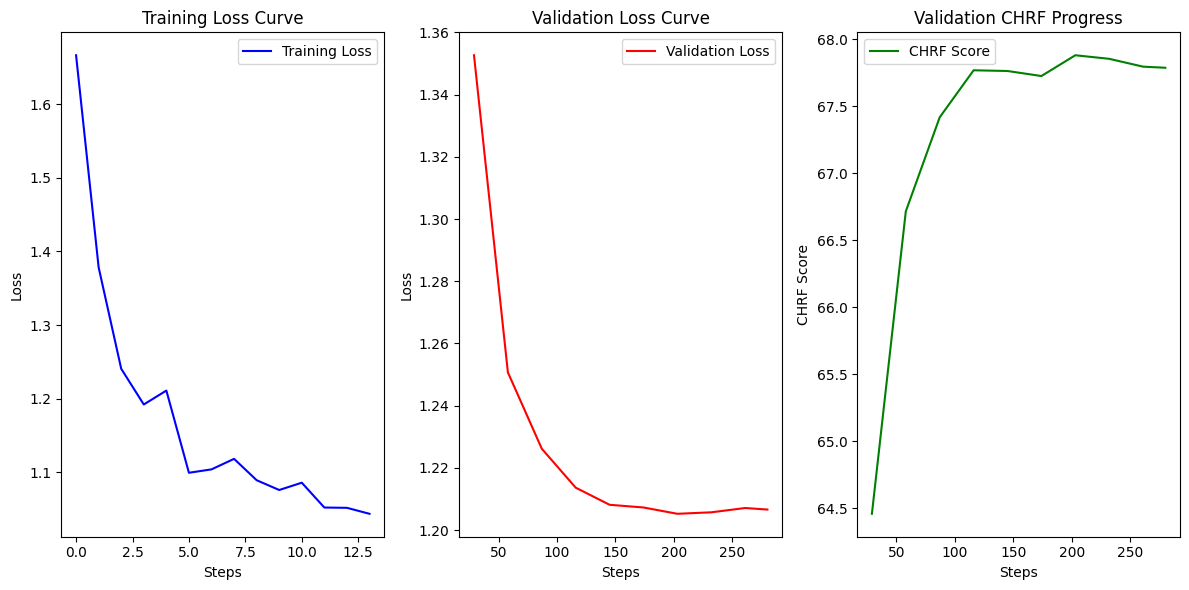

In [14]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(12, 6))
log_history = trainer.state.log_history
# Training Loss
plt.subplot(1, 3, 1)
train_loss = [x['loss'] for x in log_history if 'loss' in x]  # Extract training loss
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Validation Loss
plt.subplot(1, 3, 2)
eval_steps = [x['step'] for x in log_history if 'eval_loss' in x]
eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
plt.plot(eval_steps, eval_loss, 'r-', label='Validation Loss')
plt.title("Validation Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# CHRF Score
plt.subplot(1, 3, 3)
eval_chrf = [x['eval_chrf'] for x in log_history if 'eval_chrf' in x]
plt.plot(eval_steps, eval_chrf, 'g-', label='CHRF Score')
plt.title("Validation CHRF Progress")
plt.xlabel("Steps")
plt.ylabel("CHRF Score")
plt.legend()

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("learning_curves.png", dpi=300)
plt.show()


In [15]:
# Save final model`
model.save_pretrained("./results/fine_tuned_model")
tokenizer.save_pretrained("./results/fine_tuned_model")


('./results/fine_tuned_model/tokenizer_config.json',
 './results/fine_tuned_model/special_tokens_map.json',
 './results/fine_tuned_model/tokenizer.json')

In [16]:
chrf = evaluate.load("chrf")

def evaluate_example(model, tokenizer, test_case):
    """Evaluate a single test case"""
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Tokenize and send to correct device
    inputs = tokenizer(test_case["prompt"], return_tensors="pt").to(device)

    # Generate output
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.3,
        do_sample=True
    )

    # Decode and remove prompt from output
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_code = full_output[len(test_case["prompt"]):].strip()  # Remove prompt part

    # Compute CHRF Score
    chrf_score = chrf.compute(
        predictions=[generated_code],
        references=[test_case["solution"]],
        word_order=2,
        beta=2
    )["score"]

    return {
        "expected": test_case["solution"],
        "generated": generated_code,
        "chrf": chrf_score
    }

# Run evaluation on 5 test samples
test_samples = dataset.select(range(5))
results = [evaluate_example(model, tokenizer, s) for s in test_samples]

# Display formatted results
display(HTML("<h3>Evaluation Results:</h3>"))
for i, res in enumerate(results):
    display(HTML(f"""
    <div style='border:1px solid #ccc; padding:10px; margin:10px; border-radius:5px; background:#f9f9f9'>
        <b>Example {i+1}</b><br>
        <b>CHRF Score:</b> {res['chrf']:.2f}<br>
        <details>
            <summary>Expected Solution</summary>
            <pre style='background:#e8f0ff; padding:10px;'>{res['expected']}</pre>
        </details>
        <details>
            <summary>Generated Code</summary>
            <pre style='background:#e8ffe8; padding:10px;'>{res['generated']}</pre>
        </details>
    </div>
    """))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [21]:
def execute_test(generated_code):
    """Execute code and return test results"""
    with open("temp.py", "w") as f:
        f.write(generated_code)

    try:
        result = subprocess.run(
            ["python", "temp.py"],
            capture_output=True,
            text=True,
            timeout=10
        )
        return {
            "success": result.returncode == 0,
            "output": result.stdout,
            "error": result.stderr
        }
    except Exception as e:
        return {"success": False, "error": str(e)}

# Add execution results to evaluation
for res in results:
    execution = execute_test(res["generated"])
    res["execution"] = execution

In [18]:
# Calculate metrics
avg_chrf = np.mean([r["chrf"] for r in results])
success_rate = np.mean([1 if r.get("execution", {}).get("success") else 0 for r in results])

# Generate report
report = f"""
<h2>Final Evaluation Report</h2>
<div style='background:#f8f9fa; padding:20px'>
    <b>Average CHRF Score:</b> {avg_chrf:.2f}<br>
    <b>Execution Success Rate:</b> {success_rate*100:.1f}%<br>
    <b>Training Steps:</b> {len(trainer.state.log_history)}<br>
    <b>Final Loss:</b> {trainer.state.log_history[-1]['train_loss']:.3f}
</div>
"""

display(HTML(report))


[chrf](https://huggingface.co/spaces/evaluate-metric/chrf) \\
[jetbrains arxiv](https://arxiv.org/pdf/2406.11612) \\
[APPS](https://arxiv.org/pdf/2105.09938)
